In [21]:
# Parameters to set to run this notebook

# Initialize helpers.
import numpy as np
import project_path
from model.data_accessor import get_data_file_abs_path
from model.neuron_metadata import *
neuron_metadata_collection = NeuronMetadataCollection.load_from_chem_json(get_data_file_abs_path('chem.json'))
N = neuron_metadata_collection.get_size()

# How many seconds to run each step for. This should be long enough for stability to be observed.
step_duration_s = 20
# The step amplitudes in nA. Each amplitude will be run for step_duration
start_amp_nA = 0.5
peak_amp_nA = 3.5
amp_delta_nA = 3.0
step_amplitudes_nA = np.concatenate((np.arange(start_amp_nA, peak_amp_nA, amp_delta_nA), \
                                     np.arange(peak_amp_nA, start_amp_nA-amp_delta_nA/2, -amp_delta_nA)), axis=None)

# neurons_to_stimulate = ["PLML", "PLMR"]
neurons_to_stimulate = ["AWAR"]

# Initial condition
# If you want a fixed-seed initial condition, uncomment the line below.
# np.random.seed(0)
init_conds = 10**(-4)*np.random.normal(0, 0.94, 2*N)

enable_caching = True

In [22]:
# Setup the model
from model.neural_model import NeuralModel
from util.plot_util import *
import os
import pickle

"""
neurons_to_observe = NeuronMetadataCollection.create_lr_names_from_base([
  "AWA"
])
"""
# neurons_to_observe = ["PLML", "PLMR"]
neurons_to_observe = ["AWAR"]

model = NeuralModel(neuron_metadata_collection)
model.init_conds = init_conds

# Set I_inj_i(t)

def time_to_I_ext_fun(t):
  amp = step_amplitudes_nA[int(t / step_duration_s)]
  cur_I_ext = np.zeros(N)
  for neuron in neurons_to_stimulate:
    neuron_id = neuron_metadata_collection.get_id_from_name(neuron)
    cur_I_ext[neuron_id] = amp
  return cur_I_ext

# These are timesteps when I_ext changes
num_step_values = len(step_amplitudes_nA)
t_changes_I_ext = np.array(range(num_step_values)) * step_duration_s
t_changes_I_ext = t_changes_I_ext.tolist()
model.set_I_ext(time_to_I_ext_fun, t_changes_I_ext)

model.init_kunert_2017()

step_duration_timesteps = int(step_duration_s / model.dt)
simul_timesteps = step_duration_timesteps * len(step_amplitudes_nA)

In [23]:
# Run the model. Or not, if cached result already exists
# Cache file is about ~1MB for 1 second.
cache_key = "%d_%.2f_%.2f_%.2f_%s" % \
  (step_duration_s, start_amp_nA, peak_amp_nA, amp_delta_nA, "_".join(neurons_to_stimulate))
cache_path = "../local_results/exp_CHANGING_STEP_AWA/" + cache_key

v_normalized_mat = []
if enable_caching and os.path.isfile(cache_path):
  print("Loading saved results from pickle file {}".format(cache_path))
  with open(cache_path, "rb") as f:
    (v_mat, v_normalized_mat) = pickle.load(f)
else:
  (v_mat, s_mat, v_normalized_mat) = model.run(simul_timesteps)
  if enable_caching:
    # Update cache
    with open(cache_path, "wb") as f:
      pickle.dump((v_mat, v_normalized_mat), f)

Timestep 0 out of 6000
Timestep 100 out of 6000
Timestep 200 out of 6000
Timestep 300 out of 6000
Timestep 400 out of 6000
Timestep 500 out of 6000
Timestep 600 out of 6000
Timestep 700 out of 6000
Timestep 800 out of 6000
Timestep 900 out of 6000
Timestep 1000 out of 6000
Timestep 1100 out of 6000
Timestep 1200 out of 6000
Timestep 1300 out of 6000
Timestep 1400 out of 6000
Timestep 1500 out of 6000
Timestep 1600 out of 6000
Timestep 1700 out of 6000
Timestep 1800 out of 6000
Timestep 1900 out of 6000
Timestep 2000 out of 6000
Timestep 2100 out of 6000
Timestep 2200 out of 6000
Timestep 2300 out of 6000
Timestep 2400 out of 6000
Timestep 2500 out of 6000
Timestep 2600 out of 6000
Timestep 2700 out of 6000
Timestep 2800 out of 6000
Timestep 2900 out of 6000
Timestep 3000 out of 6000
Timestep 3100 out of 6000
Timestep 3200 out of 6000
Timestep 3300 out of 6000
Timestep 3400 out of 6000
Timestep 3500 out of 6000
Timestep 3600 out of 6000
Timestep 3700 out of 6000
Timestep 3800 out of 600

# Plot stimulus

<IPython.core.display.Javascript object>


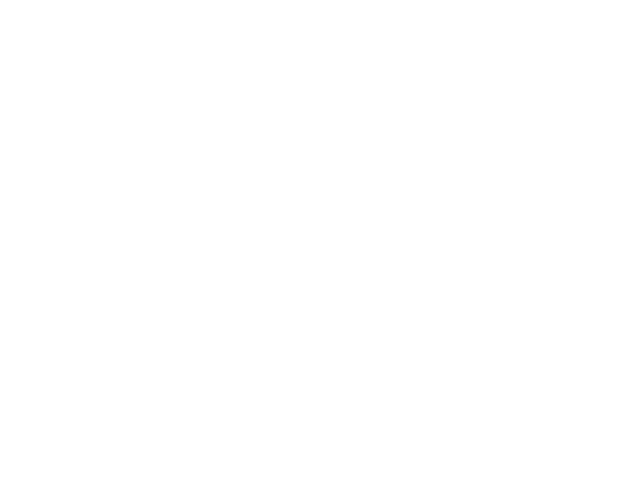

In [24]:
times = np.array(np.arange(0, simul_timesteps * model.dt, model.dt))

awar_index = neuron_metadata_collection.get_id_from_name("AWAR")
amps = [time_to_I_ext_fun(time)[awar_index] for time in times]
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(times, amps)
ax.set_title("Stimulus over time for AWAR")
ax.set_ylabel("Injected current (nA)")
ax.set_xlabel("Time (s)")
_ = _

# Plot potentials of selected neurons

<IPython.core.display.Javascript object>


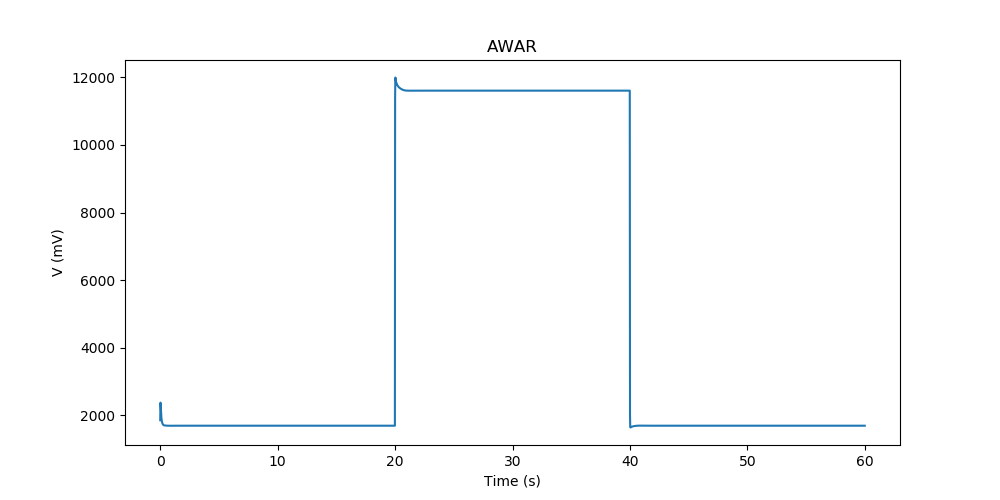

In [25]:
%matplotlib notebook
fig = plot_potentials(
  neuron_names_to_show = neurons_to_observe,
  dynamics = v_mat,
  is_normalized_v = False,
  dt = model.dt,
  neuron_metadata_collection = neuron_metadata_collection)
fig.show()

<IPython.core.display.Javascript object>


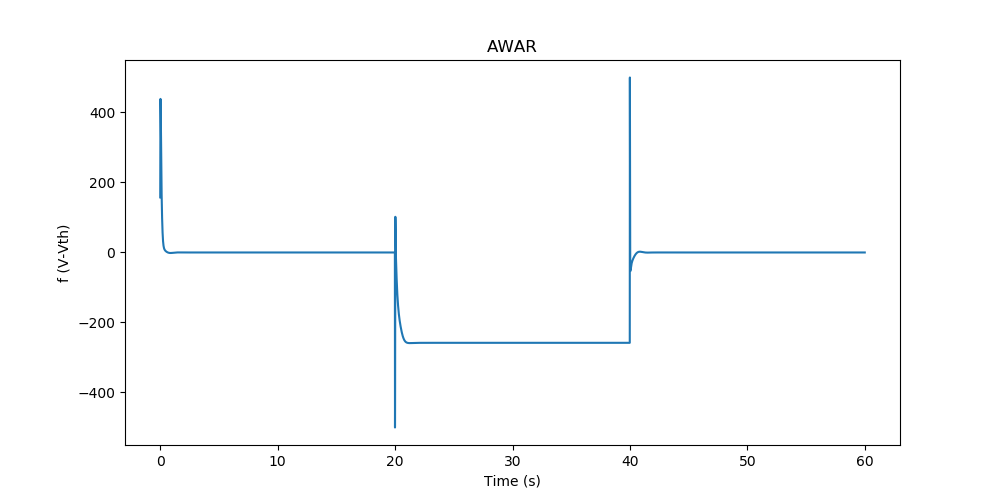

In [26]:
fig = plot_potentials(
  neuron_names_to_show = neurons_to_observe,
  dynamics = v_normalized_mat,
  is_normalized_v = True,
  dt = model.dt,
  neuron_metadata_collection = neuron_metadata_collection)
fig.show()

# Plot summarized dynamics per neuron class

<IPython.core.display.Javascript object>


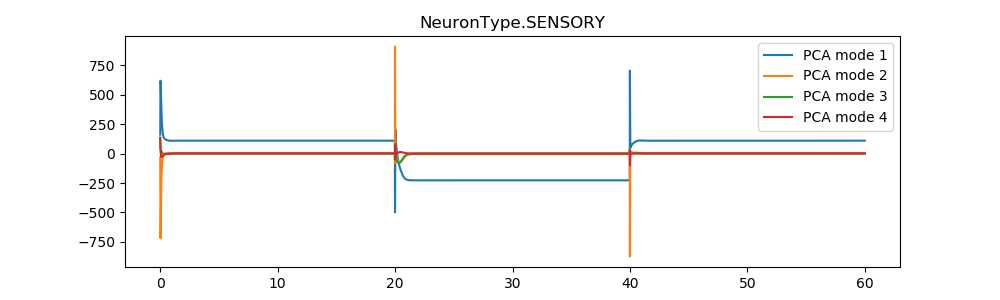

<IPython.core.display.Javascript object>


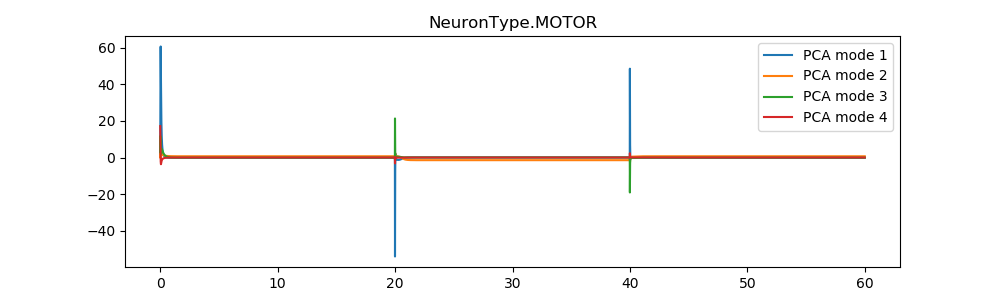

<IPython.core.display.Javascript object>


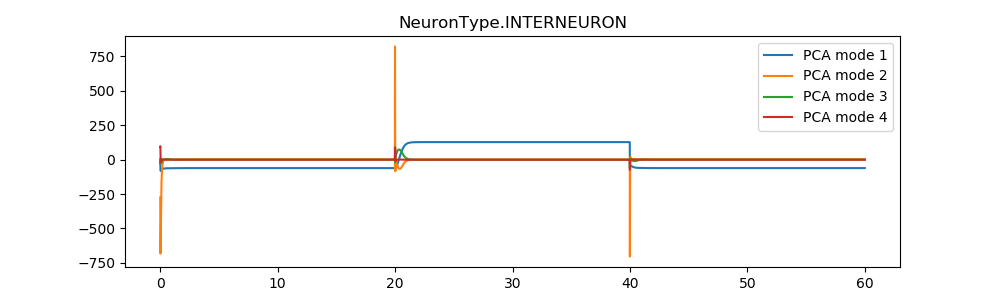

In [27]:
plot_pcas(v_normalized_mat, model.dt, neuron_metadata_collection)

# Bifurcation plot

<IPython.core.display.Javascript object>


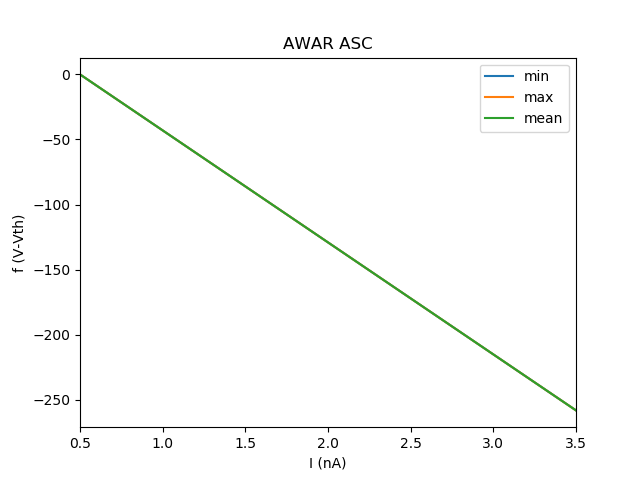

<IPython.core.display.Javascript object>


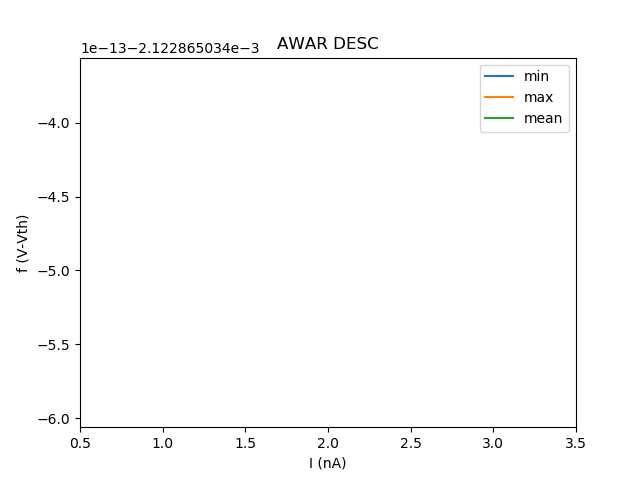

<IPython.core.display.Javascript object>


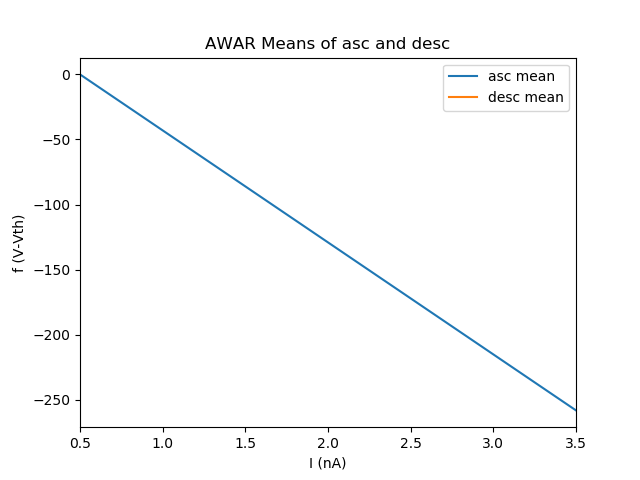

<IPython.core.display.Javascript object>


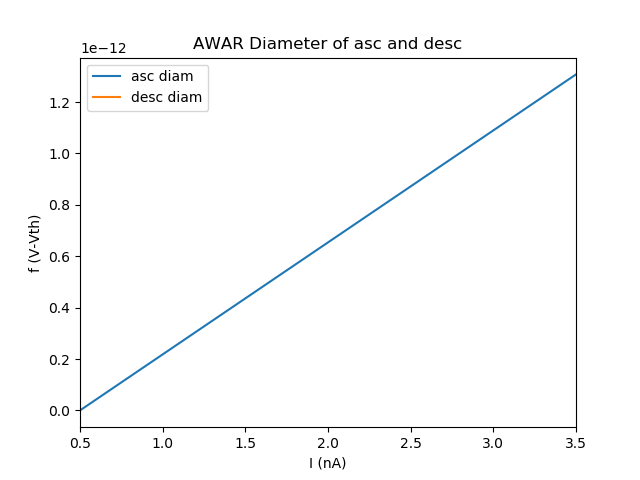

In [28]:
create_changing_step_bifurcation_plot(
    neurons_to_observe = neurons_to_observe,
    dynamics = v_normalized_mat,
    is_normalized_v = True,
    step_amps_nA = step_amplitudes_nA,
    start_amp_nA = start_amp_nA,
    peak_amp_nA = peak_amp_nA,
    amp_delta_nA = amp_delta_nA, 
    step_duration_timesteps = step_duration_timesteps,
    neuron_metadata_collection = neuron_metadata_collection)

<IPython.core.display.Javascript object>


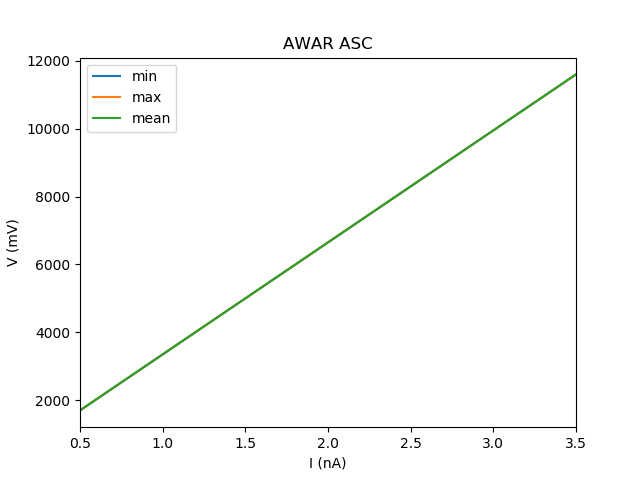

<IPython.core.display.Javascript object>


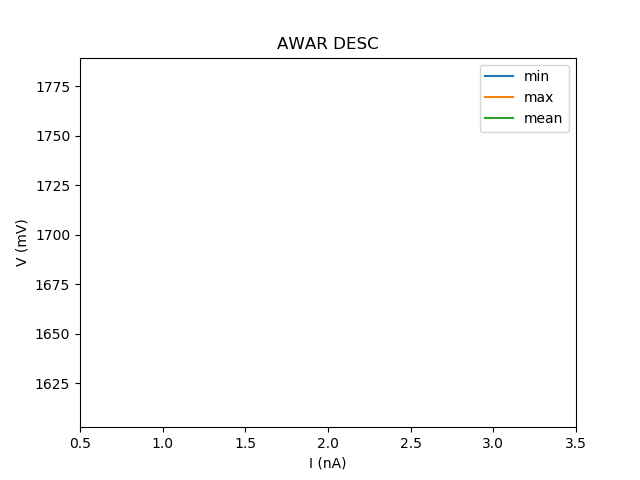

<IPython.core.display.Javascript object>


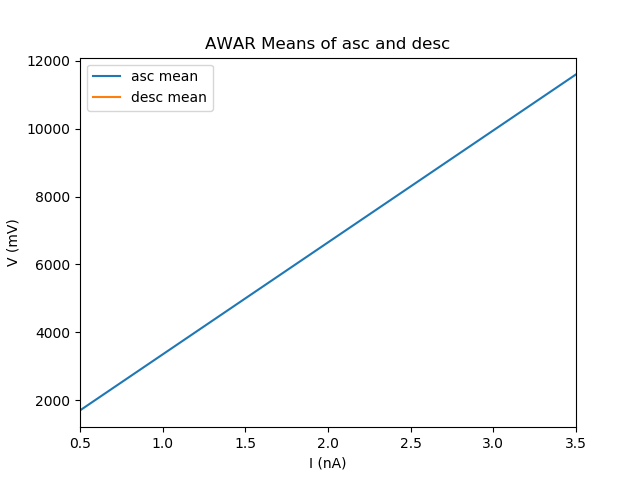

<IPython.core.display.Javascript object>


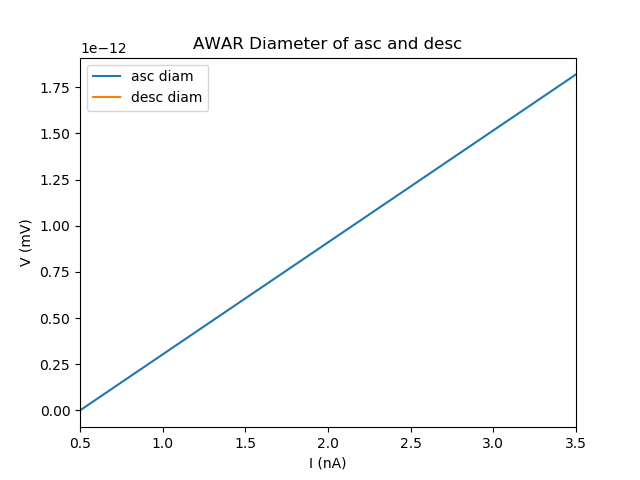

In [29]:
create_changing_step_bifurcation_plot(
    neurons_to_observe = neurons_to_observe,
    dynamics = v_mat,
    is_normalized_v = False,
    step_amps_nA = step_amplitudes_nA,
    start_amp_nA = start_amp_nA,
    peak_amp_nA = peak_amp_nA,
    amp_delta_nA = amp_delta_nA, 
    step_duration_timesteps = step_duration_timesteps,
    neuron_metadata_collection = neuron_metadata_collection)